# Template Augmentation

Experiments:
1. Perform Zero-Shot classification with template augmentation.
2. Report clusters for classes with and without template augmentation. 
3. AudioLDM Sample Classification with and without augmentation

In [1]:
import torch
from msclap import CLAP
import laion_clap
import json
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from utils.experiment_logger import ExperimentLogger
from utils.set_torch_device import set_torch_device
from utils.evaluation_utils import k_fold_zs_predict, k_fold_zs_evaluation, load_embeddings_from_disk

In [2]:
# Load Testing Set
with open ('configs/temp_aug.json', 'r') as f:
    settings = json.load (f)

device, _ = set_torch_device()

In [16]:
# Load models
msclap_model = CLAP(version = '2023', use_cuda=True) # version can be 2022 or 2023
laion_clap_model = laion_clap.CLAP_Module(enable_fusion=False)
laion_clap_model.load_ckpt()

Load our best checkpoint in the paper.
The checkpoint is already downloaded
Load Checkpoint...
logit_scale_a 	 Loaded
logit_scale_t 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_real.weight 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_imag.weight 	 Loaded
audio_branch.logmel_extractor.melW 	 Loaded
audio_branch.bn0.weight 	 Loaded
audio_branch.bn0.bias 	 Loaded
audio_branch.patch_embed.proj.weight 	 Loaded
audio_branch.patch_embed.proj.bias 	 Loaded
audio_branch.patch_embed.norm.weight 	 Loaded
audio_branch.patch_embed.norm.bias 	 Loaded
audio_branch.layers.0.blocks.0.norm1.weight 	 Loaded
audio_branch.layers.0.blocks.0.norm1.bias 	 Loaded
audio_branch.layers.0.blocks.0.attn.relative_position_bias_table 	 Loaded
audio_branch.layers.0.blocks.0.attn.qkv.weight 	 Loaded
audio_branch.layers.0.blocks.0.attn.qkv.bias 	 Loaded
audio_branch.layers.0.blocks.0.attn.proj.weight 	 Loaded
audio_branch.layers.0.blocks.0.attn.proj.bias 	 Loaded
audio_branch.layers.0.blocks.0.norm2.we

## Template Augmentation

This section evaluates MSCLAP and LAION CLAP on Zero Shot classification where the classes are augmented by templates.

In [51]:
k_fold_200_audio_embeddings_laion = load_embeddings_from_disk(settings["laion_audio_embeddings"])
k_fold_200_audio_embeddings_msclap = load_embeddings_from_disk(settings["msclap_audio_embeddings"])
experiment_logger = ExperimentLogger("logs/", "unnamed_log")

unnamed_log


In [166]:
results = {}
temp_aug = settings['template_augmentations']
for template in temp_aug:
    msclap_k_fold_200_gold_labels, msclap_k_fold_200_pred_labels = k_fold_zs_predict(settings,k_fold_200_audio_embeddings_msclap, msclap_model.get_text_embeddings, msclap_model.compute_similarity, device=device, temp_aug=template)
    msclap_k_fold_200_accuracy, msclap_k_fold_200_precision, msclap_k_fold_200_recall, msclap_k_fold_200_f1, msclap_k_fold_200_ap = k_fold_zs_evaluation(msclap_k_fold_200_gold_labels, msclap_k_fold_200_pred_labels)

    print(f"MSCLAP Accuracy Score: {msclap_k_fold_200_accuracy}")
    print(f"MSCLAP Average Precision Score: {msclap_k_fold_200_ap}")
    print(f"MSCLAP Precision Score: {msclap_k_fold_200_precision}")
    print(f"MSCLAP Recall Score: {msclap_k_fold_200_recall}")
    print(f"MSCLAP F1 Score: {msclap_k_fold_200_f1}")

    laion_k_fold_200_gold_labels, laion_k_fold_200_pred_labels = k_fold_zs_predict(settings, k_fold_200_audio_embeddings_laion, laion_clap_model.get_text_embedding, torch.cosine_similarity, device=device, temp_aug=template)
    laion_k_fold_200_accuracy, laion_k_fold_200_precision, laion_k_fold_200_recall, laion_k_fold_200_f1, laion_k_fold_200_ap = k_fold_zs_evaluation(laion_k_fold_200_gold_labels, laion_k_fold_200_pred_labels)

    print(f"LAION Accuracy Score: {laion_k_fold_200_accuracy}")
    print(f"LAION Average Precision Score: {laion_k_fold_200_ap}")
    print(f"LAION Precision Score: {laion_k_fold_200_precision}")
    print(f"LAION Recall Score: {laion_k_fold_200_recall}")
    print(f"LAION F1 Score: {laion_k_fold_200_f1}")

    template_name = "clean" if (template == "") else template.strip()
    results[template_name] = {
        "msclap" : {
            "accuracy" : msclap_k_fold_200_accuracy,
            "recall" : msclap_k_fold_200_recall,
            "precision" : msclap_k_fold_200_precision,
            "f1" : msclap_k_fold_200_f1
        },
        "laion" : {
            "accuracy" : laion_k_fold_200_accuracy,
            "recall" : laion_k_fold_200_recall,
            "precision" : laion_k_fold_200_precision,
            "f1" : laion_k_fold_200_f1
        }
    }

experiment_logger.experiment_name = "kfold200-zero_shot_temp_aug"
experiment_logger.log_results(results)
experiment_logger.save_log()

100%|██████████| 200/200 [01:47<00:00,  1.87it/s]


MSCLAP Accuracy Score: 0.26654320987654323
MSCLAP Average Precision Score: 0.01472771779410438
MSCLAP Precision Score: 0.3107401820657017
MSCLAP Recall Score: 0.26654320987654323
MSCLAP F1 Score: 0.23735447066717857


100%|██████████| 200/200 [01:11<00:00,  2.80it/s]


LAION Accuracy Score: 0.23104938271604938
LAION Average Precision Score: 0.01025830237141868
LAION Precision Score: 0.24843351111542056
LAION Recall Score: 0.22823170731707318
LAION F1 Score: 0.20479072247756694


100%|██████████| 200/200 [01:46<00:00,  1.88it/s]


MSCLAP Accuracy Score: 0.2971604938271605
MSCLAP Average Precision Score: 0.012465159420421366
MSCLAP Precision Score: 0.3636249451556336
MSCLAP Recall Score: 0.2935365853658537
MSCLAP F1 Score: 0.2891092213396299


100%|██████████| 200/200 [01:11<00:00,  2.79it/s]


LAION Accuracy Score: 0.23222222222222222
LAION Average Precision Score: 0.009679317660060648
LAION Precision Score: 0.239720968441469
LAION Recall Score: 0.22939024390243906
LAION F1 Score: 0.20057795702180298


100%|██████████| 200/200 [01:46<00:00,  1.87it/s]


MSCLAP Accuracy Score: 0.32481481481481483
MSCLAP Average Precision Score: 0.011603778519228477
MSCLAP Precision Score: 0.37346285817349106
MSCLAP Recall Score: 0.3208536585365854
MSCLAP F1 Score: 0.30731775184585797


100%|██████████| 200/200 [01:11<00:00,  2.78it/s]


LAION Accuracy Score: 0.18425925925925926
LAION Average Precision Score: 0.014245092642991855
LAION Precision Score: 0.21459906792737518
LAION Recall Score: 0.18201219512195121
LAION F1 Score: 0.15265820145172562


100%|██████████| 200/200 [01:42<00:00,  1.95it/s]


MSCLAP Accuracy Score: 0.3071604938271605
MSCLAP Average Precision Score: 0.009921295769968894
MSCLAP Precision Score: 0.38176881284650577
MSCLAP Recall Score: 0.30341463414634146
MSCLAP F1 Score: 0.30096318496243984


100%|██████████| 200/200 [01:06<00:00,  3.03it/s]


LAION Accuracy Score: 0.20191358024691358
LAION Average Precision Score: 0.011474413773615764
LAION Precision Score: 0.18992739048039362
LAION Recall Score: 0.19945121951219516
LAION F1 Score: 0.15851161626524662


100%|██████████| 200/200 [01:36<00:00,  2.07it/s]


MSCLAP Accuracy Score: 0.32098765432098764
MSCLAP Average Precision Score: 0.011762603522028616
MSCLAP Precision Score: 0.3799879269299947
MSCLAP Recall Score: 0.3170731707317074
MSCLAP F1 Score: 0.30451537031827397


100%|██████████| 200/200 [01:06<00:00,  3.01it/s]


LAION Accuracy Score: 0.1895679012345679
LAION Average Precision Score: 0.01178556604719638
LAION Precision Score: 0.19641937605317764
LAION Recall Score: 0.1872560975609756
LAION F1 Score: 0.15789457147317307


100%|██████████| 200/200 [01:36<00:00,  2.08it/s]


MSCLAP Accuracy Score: 0.29833333333333334
MSCLAP Average Precision Score: 0.012062113107470573
MSCLAP Precision Score: 0.3733880967309567
MSCLAP Recall Score: 0.2946951219512195
MSCLAP F1 Score: 0.28457309760386384


100%|██████████| 200/200 [01:06<00:00,  3.02it/s]


LAION Accuracy Score: 0.1921604938271605
LAION Average Precision Score: 0.009303540622414662
LAION Precision Score: 0.208623665917182
LAION Recall Score: 0.1898170731707317
LAION F1 Score: 0.15865814218382354


100%|██████████| 200/200 [01:36<00:00,  2.07it/s]


MSCLAP Accuracy Score: 0.19444444444444445
MSCLAP Average Precision Score: 0.010553343441452664
MSCLAP Precision Score: 0.3762213033608441
MSCLAP Recall Score: 0.19444444444444445
MSCLAP F1 Score: 0.2107414419153064


100%|██████████| 200/200 [01:06<00:00,  3.02it/s]


LAION Accuracy Score: 0.19913580246913581
LAION Average Precision Score: 0.012869101917981322
LAION Precision Score: 0.1993226108068851
LAION Recall Score: 0.1991358024691358
LAION F1 Score: 0.1611368568120241


100%|██████████| 200/200 [01:36<00:00,  2.07it/s]


MSCLAP Accuracy Score: 0.2995679012345679
MSCLAP Average Precision Score: 0.011483767081852671
MSCLAP Precision Score: 0.3642239103957802
MSCLAP Recall Score: 0.2995679012345679
MSCLAP F1 Score: 0.28887439914722396


100%|██████████| 200/200 [01:06<00:00,  3.02it/s]


LAION Accuracy Score: 0.2080246913580247
LAION Average Precision Score: 0.012478322572331318
LAION Precision Score: 0.1696854349412193
LAION Recall Score: 0.20802469135802468
LAION F1 Score: 0.16181554805379283


100%|██████████| 200/200 [01:36<00:00,  2.07it/s]


MSCLAP Accuracy Score: 0.2767901234567901
MSCLAP Average Precision Score: 0.012330446510477084
MSCLAP Precision Score: 0.3581488253649656
MSCLAP Recall Score: 0.2734146341463415
MSCLAP F1 Score: 0.2578509821669046


100%|██████████| 200/200 [01:06<00:00,  3.01it/s]


LAION Accuracy Score: 0.22160493827160493
LAION Average Precision Score: 0.014342469476984377
LAION Precision Score: 0.20835675373801213
LAION Recall Score: 0.22160493827160493
LAION F1 Score: 0.17044542014589406


100%|██████████| 200/200 [01:36<00:00,  2.07it/s]


MSCLAP Accuracy Score: 0.2574074074074074
MSCLAP Average Precision Score: 0.010158056905003434
MSCLAP Precision Score: 0.35930768307931427
MSCLAP Recall Score: 0.25426829268292683
MSCLAP F1 Score: 0.24198930332952273


100%|██████████| 200/200 [01:06<00:00,  3.01it/s]


LAION Accuracy Score: 0.17530864197530865
LAION Average Precision Score: 0.015712837590308733
LAION Precision Score: 0.15294169502673802
LAION Recall Score: 0.17317073170731706
LAION F1 Score: 0.13368707278338393


100%|██████████| 200/200 [01:36<00:00,  2.07it/s]


MSCLAP Accuracy Score: 0.2567283950617284
MSCLAP Average Precision Score: 0.009952314555320557
MSCLAP Precision Score: 0.33396429230481445
MSCLAP Recall Score: 0.25359756097560976
MSCLAP F1 Score: 0.2308368897515076


100%|██████████| 200/200 [01:06<00:00,  3.02it/s]


LAION Accuracy Score: 0.16240740740740742
LAION Average Precision Score: 0.012687649415431702
LAION Precision Score: 0.18652490647378997
LAION Recall Score: 0.1604268292682927
LAION F1 Score: 0.13664317807632886


100%|██████████| 200/200 [01:36<00:00,  2.07it/s]


MSCLAP Accuracy Score: 0.2776543209876543
MSCLAP Average Precision Score: 0.010782318625274161
MSCLAP Precision Score: 0.2875486268767259
MSCLAP Recall Score: 0.2742682926829268
MSCLAP F1 Score: 0.23086787137342984


100%|██████████| 200/200 [01:06<00:00,  3.01it/s]

LAION Accuracy Score: 0.17969135802469136
LAION Average Precision Score: 0.013725862014976994
LAION Precision Score: 0.16635040427787162
LAION Recall Score: 0.17750000000000002
LAION F1 Score: 0.12850839767468708


## 2D Embedding Projection with PCA

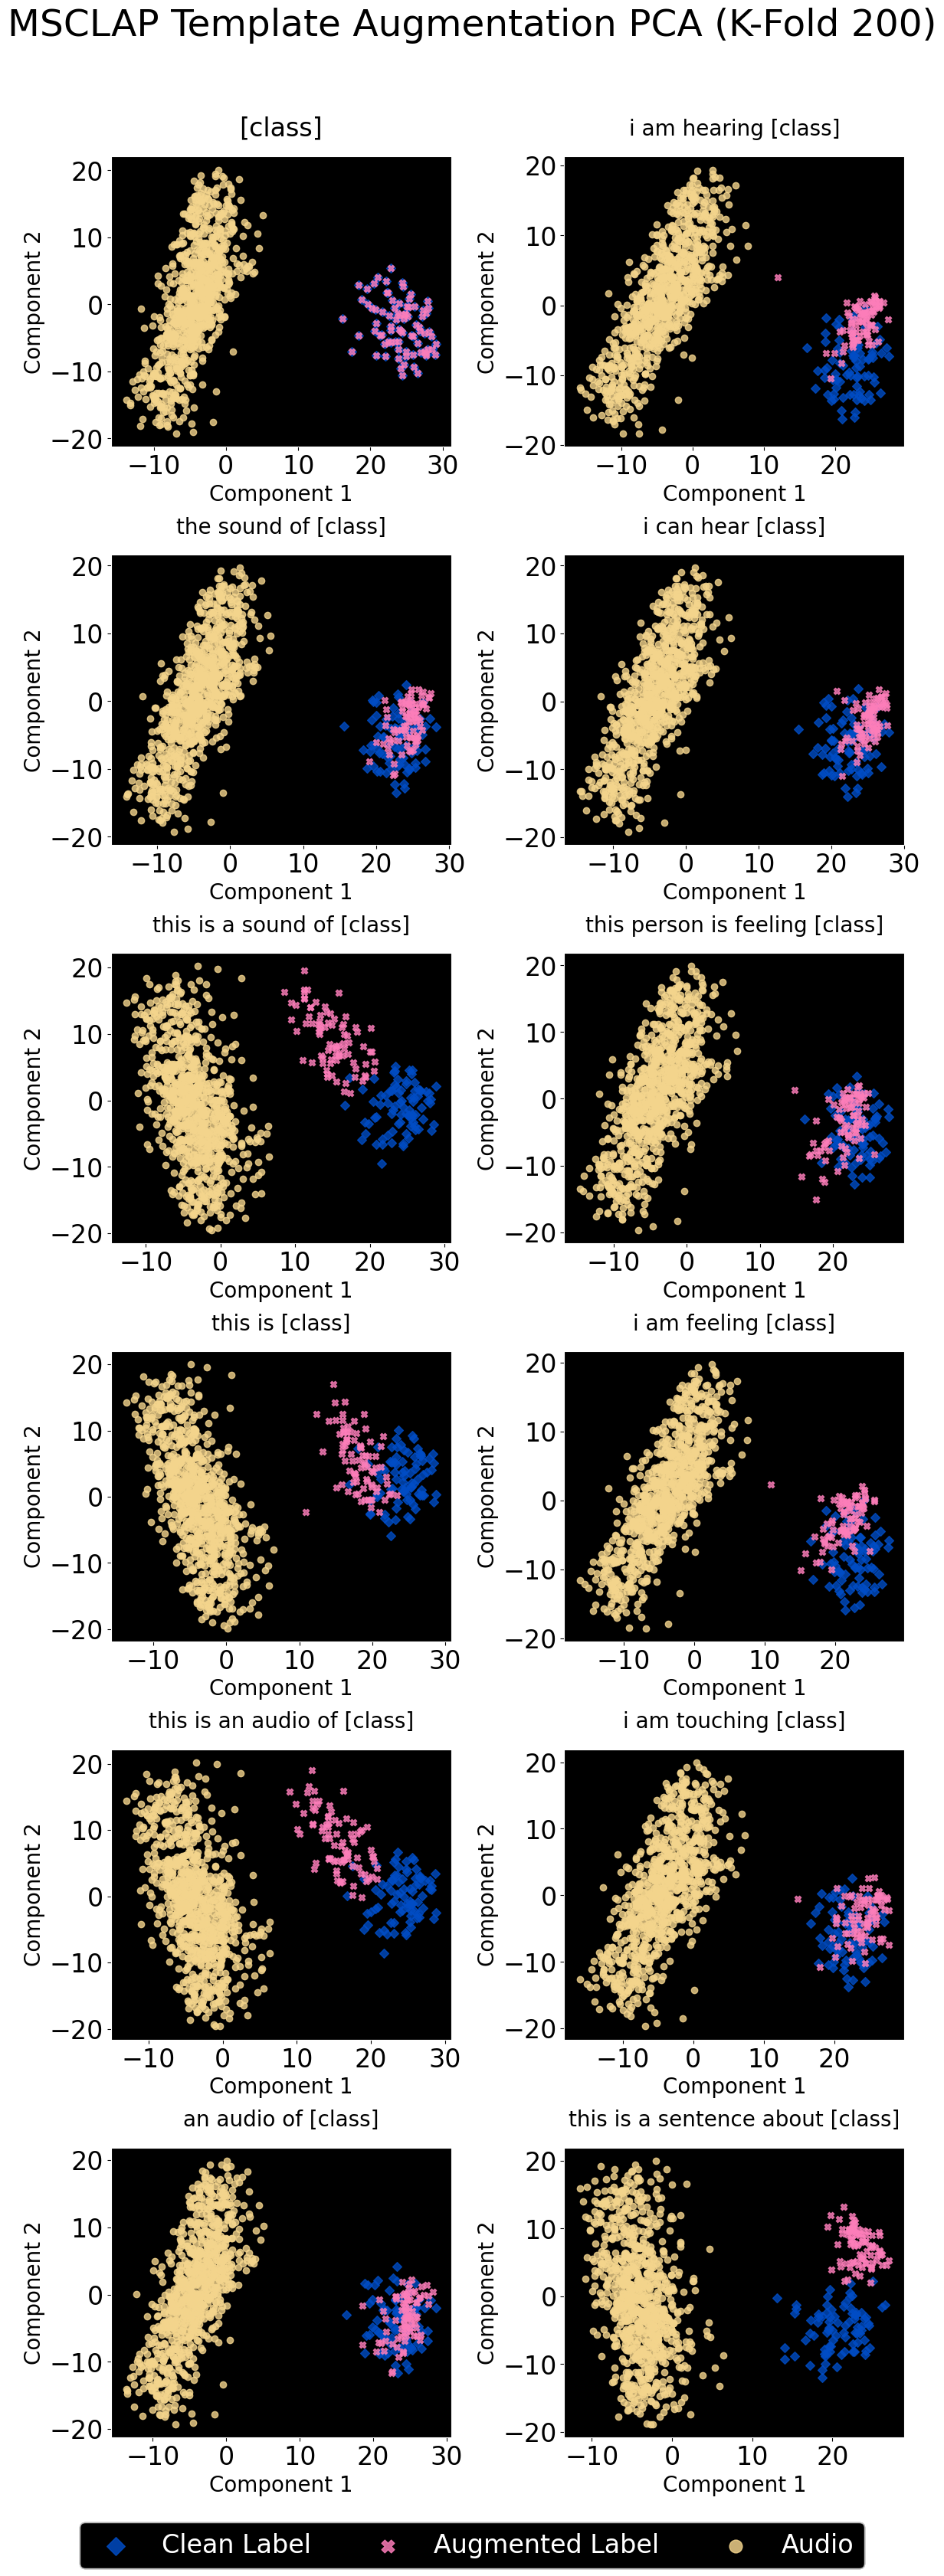

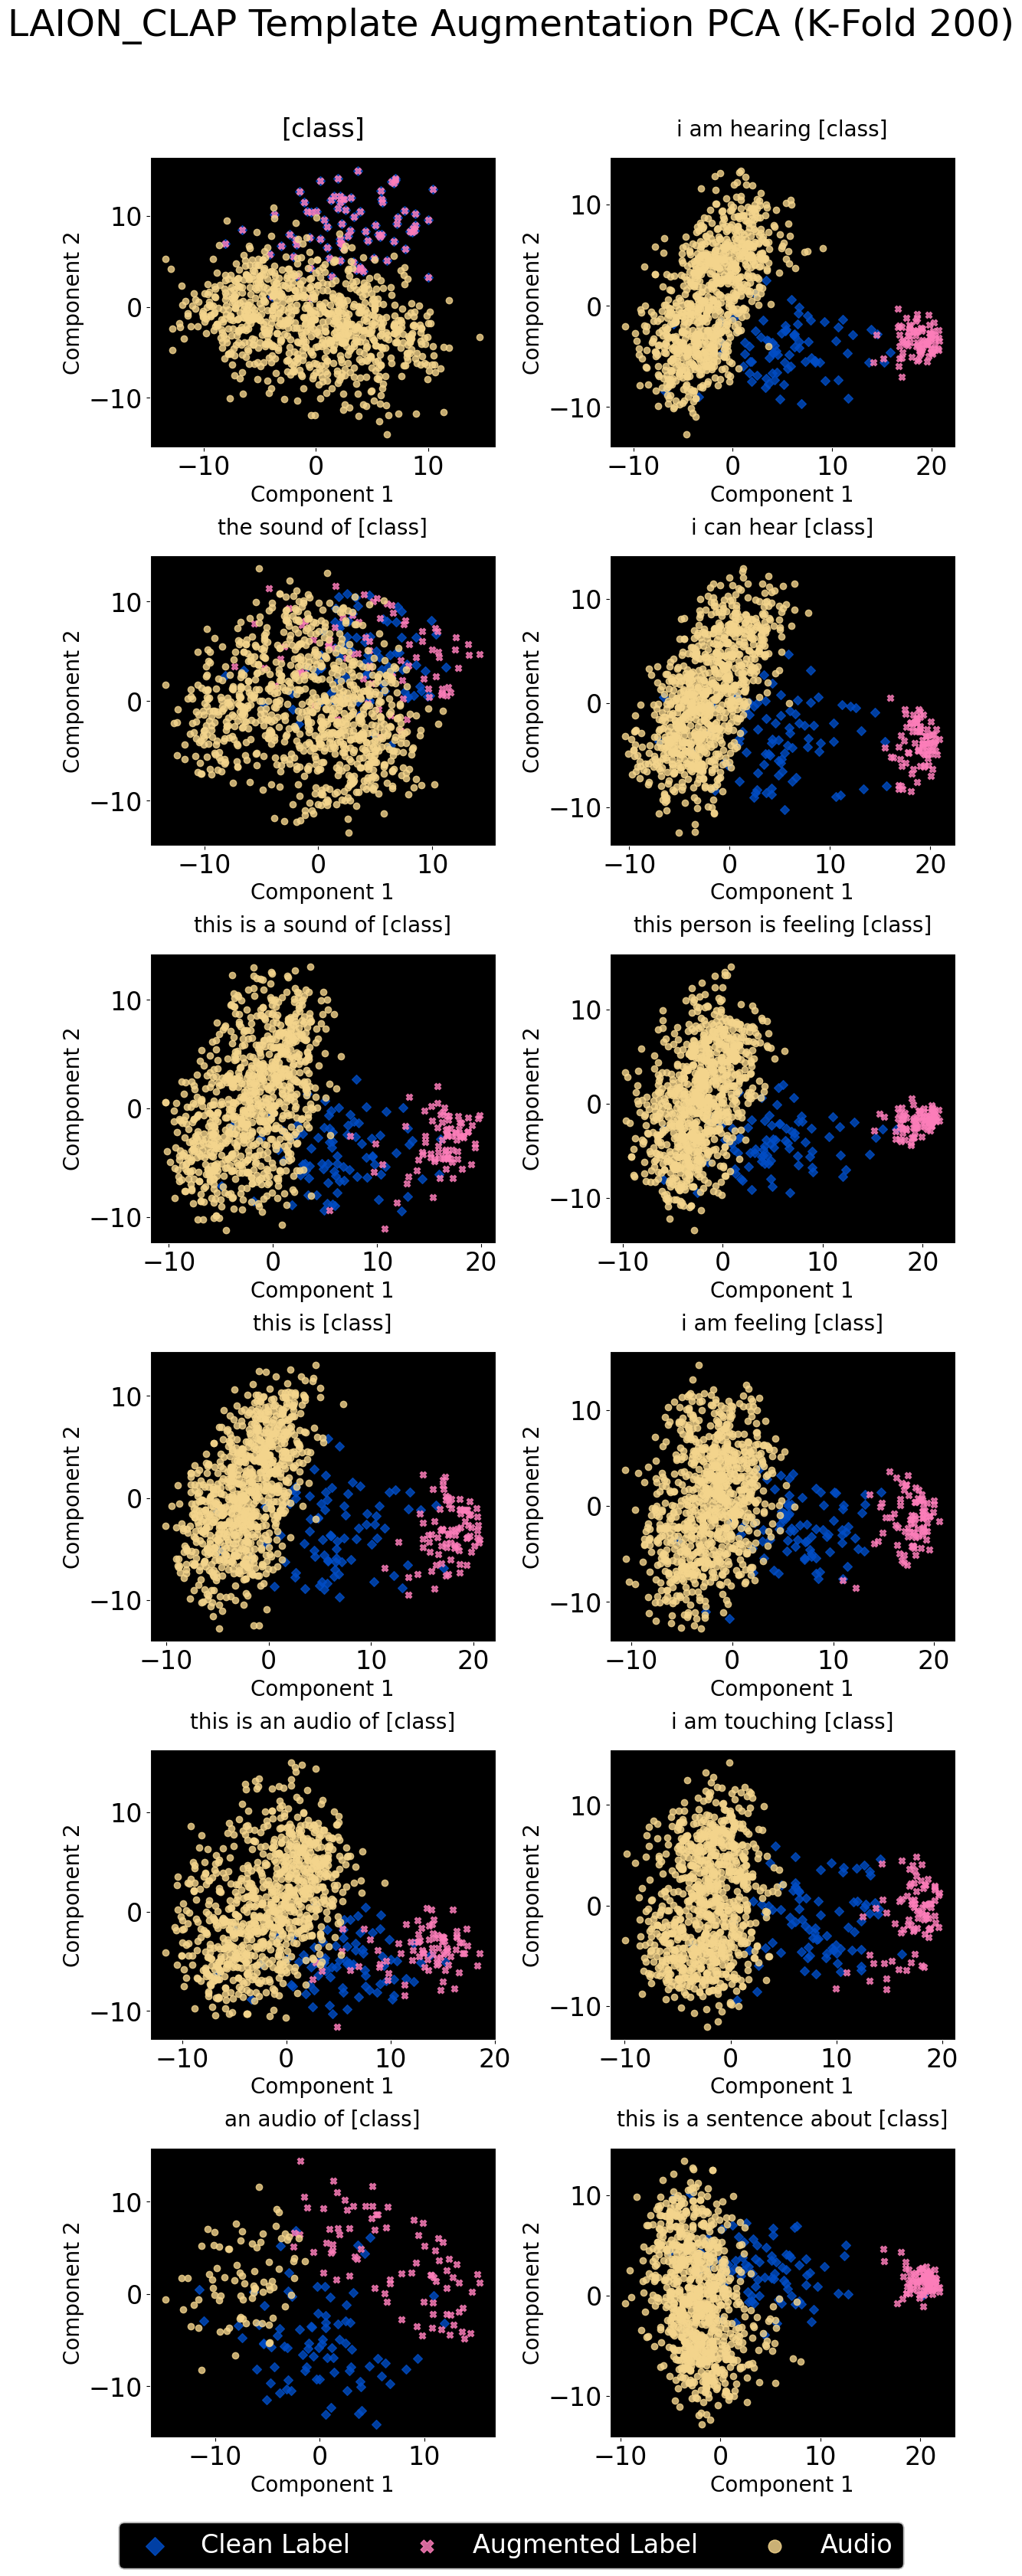

In [98]:
################
### SETTINGS ###
################

seed = 1337
audio_folds_to_project = 10 # 1 to 200. 0 will only project text embeddings.
plot_explained_var = False # Explained variance bars instead of PCA plots.
experiment_logger.experiment_name = f"kfold200-zero_shot-cluster_parameters"

##################
### EXTRACTION ###
##################

# Load USC Classes
with open (settings['class_converter'], 'r') as f:
    ucs_classes = json.load(f)

with open (settings['class_converter'], 'r') as f:
    ucs_classes_aug = json.load(f)

temp_augs = settings['template_augmentations']
# TODO: Make organizing the plot more elegant.
ax_titles = [
    [temp_augs[0], temp_augs[1], temp_augs[2], temp_augs[3], temp_augs[4], temp_augs[5]], 
    [temp_augs[6], temp_augs[7], temp_augs[8], temp_augs[9], temp_augs[10], temp_augs[11]]
]

results = {}

#plt.style.use('dark_background')
plt.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "black",
    "axes.facecolor": "black", # Backgrond
    "axes.edgecolor": "white", # Borders
    "axes.labelcolor": "black",
    "xtick.color": "black",
    "ytick.color": "black",
    "grid.color": "lightgray",
    "legend.facecolor": "black",
    "legend.labelcolor" : "white",
    "figure.facecolor": "white",
    "figure.edgecolor": "white",
    "savefig.facecolor": "white",
    "savefig.edgecolor": "white"})  

class_names = ['Clean Label','Augmented Label', 'Audio']
#for i in range(audio_folds_to_project):
#    class_names.append(f"Audio Fold {i+1}")

# TODO: Create functions for this process.
for model_name in ["MSCLAP", "LAION_CLAP"]:
    fig, axes = plt.subplots(len(temp_augs) // 2, 2, figsize=(12,32))
    fig.suptitle(f"{model_name} Template Augmentation PCA (K-Fold 200)", fontsize=35, y=1.02)
    results[model_name] = {}
    for i, axes_row in enumerate(axes): # i = [0, 1]
        for j, ax in enumerate(axes_row): # j = [0, 4]
            stacked_embeddings = None # Flush variable, since it's shared between models and used for concatenation.
            current_template = ax_titles[j][i] # Must match shape of subplots
            
            if (current_template != ""):
                ucs_classes_aug['class_to_int'] = {current_template+k:v for (k,v) in ucs_classes['class_to_int'].items()}
                ucs_classes_aug['int_to_class'] = {k:current_template+v for (k,v) in ucs_classes['int_to_class'].items()}
                ax.set_title(f"{current_template.strip()} [class]", fontsize=20, pad=20)
            else:
                # Precausion in case this cell is run again before restarting the kernel
                ucs_classes_aug['class_to_int'] = ucs_classes['class_to_int']
                ucs_classes_aug['int_to_class'] = ucs_classes['int_to_class']
                ax.set_title("[class]", fontsize=24, pad=20)

            if (model_name == "MSCLAP"):
                # Extract embeddings for model 1
                msclap_cls_embeddings = msclap_model.get_text_embeddings(list(ucs_classes['class_to_int'].keys()))
                msclap_cls_embeddings_aug = msclap_model.get_text_embeddings(list(ucs_classes_aug['class_to_int'].keys()))
                stacked_embeddings = torch.concat((msclap_cls_embeddings, msclap_cls_embeddings_aug), dim=0)
                
                if (audio_folds_to_project > 0):
                    stacked_embeddings = torch.concat((stacked_embeddings, k_fold_200_audio_embeddings_msclap[0]), dim=0)
                    for k, fold_msclap in enumerate(k_fold_200_audio_embeddings_msclap[1:]): 
                        stacked_embeddings = torch.concat((stacked_embeddings, fold_msclap), dim=0)

                        if (k == audio_folds_to_project-1) : break # Add k audio folds
                

            if (model_name == "LAION_CLAP"):
                # Extract embeddings for model 2
                laion_cls_embeddings = laion_clap_model.get_text_embedding(list(ucs_classes['class_to_int'].keys()), use_tensor=True)
                laion_cls_embeddings_aug = laion_clap_model.get_text_embedding(list(ucs_classes_aug['class_to_int'].keys()), use_tensor=True)
                stacked_embeddings = torch.concat((laion_cls_embeddings, laion_cls_embeddings_aug), dim=0)

                if (audio_folds_to_project > 0):
                    stacked_embeddings = torch.concat((stacked_embeddings, k_fold_200_audio_embeddings_laion[0]), dim=0)
                    # Add k random audio folds to the embedding stack
                    for k, fold_laion in enumerate(k_fold_200_audio_embeddings_laion[random.randint(1, k_fold_200_audio_embeddings_laion.shape[0]):]) : 
                        stacked_embeddings = torch.concat((stacked_embeddings, fold_laion), dim=0)
                        if (k == audio_folds_to_project-1) : break

            if (plot_explained_var):
                pca = PCA(n_components=.95) # n_components=0.95 equal to 95% of the variance. Use int for exact number.
                pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
                pca_components = pipe.fit_transform(stacked_embeddings.detach().cpu().numpy())

                ax.set_xlabel("Components", fontsize=16)
                ax.set_ylabel("Variance Proportion",fontsize=16)
                ax.tick_params(axis='both', which='both', labelsize=16)
                exp_var = pipe.get_params()['pca'].explained_variance_ratio_
                print(f"{model_name} Explained Variance Component 1: {exp_var[0]} and Component 2: {exp_var[1]}")
                ax.set_xticks(np.arange(0, 80, 10))
                ax.grid(visible=True, axis='x', linestyle='--', linewidth=1)
                ax.plot(exp_var, color='#004DC6', linewidth=2)

            else:
                pca = PCA(n_components=2)
                # remove mean, scale to unit variance
                pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
                
                projection_2d = pipe.fit_transform(stacked_embeddings.detach().cpu().numpy())

                samples_per_class = len(ucs_classes['class_to_int'].keys()) # Track where each class is in the vertical stack of samples

                ax.set_xlabel("Component 1", fontsize=20)
                ax.set_ylabel("Component 2",fontsize=20)
                ax.tick_params(axis='both', which='both', labelsize=24)
                ax.set_xticks(np.arange(-20, 40, 10))
                #Plot labels and classes.
                # Row Stack: Clean labels: 0 to n_classes, Aug labels: n_classes to n_aug_classes, and audio is stacked on top of that.
                temp = current_template if (current_template != "") else "clean"
                results[model_name][temp] = {}
                for n, name in enumerate(class_names):
                    color = '#F4D58D' # Default color
                    marker = 'o' # Default marker
                    x = projection_2d[n*samples_per_class:(n+1)*samples_per_class:,0]
                    y = projection_2d[n*samples_per_class:(n+1)*samples_per_class:,1]

                    if("clean" in name.lower()):
                        color = '#004DC6'
                        marker = 'D'

                        results[model_name][temp]['clean'] = {
                            "mean" : projection_2d[n*samples_per_class:(n+1)*samples_per_class:].mean(),
                            "variance" : projection_2d[n*samples_per_class:(n+1)*samples_per_class:].var(),
                            "std" : projection_2d[n*samples_per_class:(n+1)*samples_per_class:].std(),
                        }

                    if ("augmented" in name.lower()):
                        color = '#fd7eba'
                        marker = 'X'

                        results[model_name][temp]['augmented'] = {
                            "mean" : projection_2d[n*samples_per_class:(n+1)*samples_per_class:].mean(),
                            "variance" : projection_2d[n*samples_per_class:(n+1)*samples_per_class:].var(),
                            "std" : projection_2d[n*samples_per_class:(n+1)*samples_per_class:].std(),
                        }

                    if("audio" in name.lower()):
                        name = "Audio"
                        x = projection_2d[n*samples_per_class::,0]
                        y = projection_2d[n*samples_per_class::,1]

                        results[model_name][temp]['audio'] = {
                            "mean" : projection_2d[n*samples_per_class::].mean(),
                            "variance" : projection_2d[n*samples_per_class::].var(),
                            "std" : projection_2d[n*samples_per_class::].std(),
                        }

                    

                    ax.scatter(
                        x, # Column 0, i.e. PCA Component 1
                        y, # Column 1, i.e. PCA Component 2
                        label=name, marker=marker, c=color, cmap=plt.cm.tab20b, alpha=.8) #cmaps: tab20b, magma
                    
                    handle, label = ax.get_legend_handles_labels()

                    experiment_logger.log_results(results)
                
                fig.legend(handle, label, loc='lower center', fontsize="24", ncol=3, bbox_to_anchor=[0.5, -0.03], markerscale=2)       


    plt.tight_layout()

experiment_logger.save_log()

#plt.savefig(f"{model_name.lower()}-template_augmentation-scaled_pca-contrastive.png", dpi=360, bbox_inches="tight")


## 2D Embedding Projection with t-SNE
This experiment is run end-to-end for each template due to memory constraints. The variable template_idx cycles through the templates in the config/settings json file.

In [51]:
################
### SETTINGS ###
################

preplexities = [5, 30, 50, 100]
seed = 1337
tsne_iterations = 5000
template_idx = 0

##################
### EXTRACTION ###
##################

# Load USC Classes
with open (settings['class_converter'], 'r') as f:
    ucs_classes = json.load (f) 

with open (settings['class_converter'], 'r') as f:
    ucs_classes_aug = json.load (f)

results = {}
template = settings['template_augmentations'][template_idx]

if (template != ""):
    ucs_classes_aug['class_to_int'] = {template+k:v for (k,v) in ucs_classes['class_to_int'].items()}
    ucs_classes_aug['int_to_class'] = {k:template+v for (k,v) in ucs_classes['int_to_class'].items()}

# Extract embeddings for model 1
msclap_cls_embeddings = msclap_model.get_text_embeddings(list(ucs_classes['class_to_int'].keys()))
msclap_cls_embeddings_aug = msclap_model.get_text_embeddings(list(ucs_classes_aug['class_to_int'].keys()))
msclap_stacked_text_embeddings = torch.concat((msclap_cls_embeddings, msclap_cls_embeddings_aug), dim=0)
msclap_pca = PCA(n_components=75).fit_transform(msclap_stacked_text_embeddings.detach().cpu().numpy())

msclap_projected_embs = []
for preplexity in preplexities:
    msclap_projected_embs.append(TSNE(n_components=2, perplexity=preplexity, n_iter=tsne_iterations, random_state=seed).fit_transform(msclap_pca))

# Extract embeddings for model 2
laion_cls_embeddings = laion_clap_model.get_text_embedding(list(ucs_classes['class_to_int'].keys()), use_tensor=True)
laion_cls_embeddings_aug = laion_clap_model.get_text_embedding(list(ucs_classes_aug['class_to_int'].keys()), use_tensor=True)
laion_stacked_text_embeddings = torch.concat((laion_cls_embeddings, laion_cls_embeddings_aug), dim=0)
laion_pca = PCA(n_components=75).fit_transform(laion_stacked_text_embeddings.detach().cpu().numpy()) # Reduced to 75 components first.

laion_projected_embs = []
for preplexity in preplexities:
    laion_projected_embs.append(TSNE(n_components=2, perplexity=preplexity, n_iter=tsne_iterations, random_state=seed).fit_transform(laion_pca))

template_name = "clean" if (template == "") else template.strip()
# The augmented embeddings are the only ones logged, as one possible augmentation in the settings is set to no augmentation
results[template_name] = {
    "seed": seed,
    "tsne_iterations" : tsne_iterations,
    "msclap" : {
        "mean_aug" : msclap_cls_embeddings_aug.detach().cpu().numpy().mean(),
        "variance_aug" : msclap_cls_embeddings_aug.detach().cpu().numpy().var(),
        "std_aug" : msclap_cls_embeddings_aug.detach().cpu().numpy().std(),
    },
    "laion" : {
        "mean_aug" : laion_cls_embeddings_aug.detach().cpu().numpy().mean(),
        "variance_aug" : laion_cls_embeddings_aug.detach().cpu().numpy().var(),
        "std_aug" : laion_cls_embeddings_aug.detach().cpu().numpy().std(),
    }
}

experiment_logger.experiment_name = f"kfold200-zero_shot-template_idx_{template_idx}-cluster_parameters"
experiment_logger.log_results(results)
#experiment_logger.save_log()


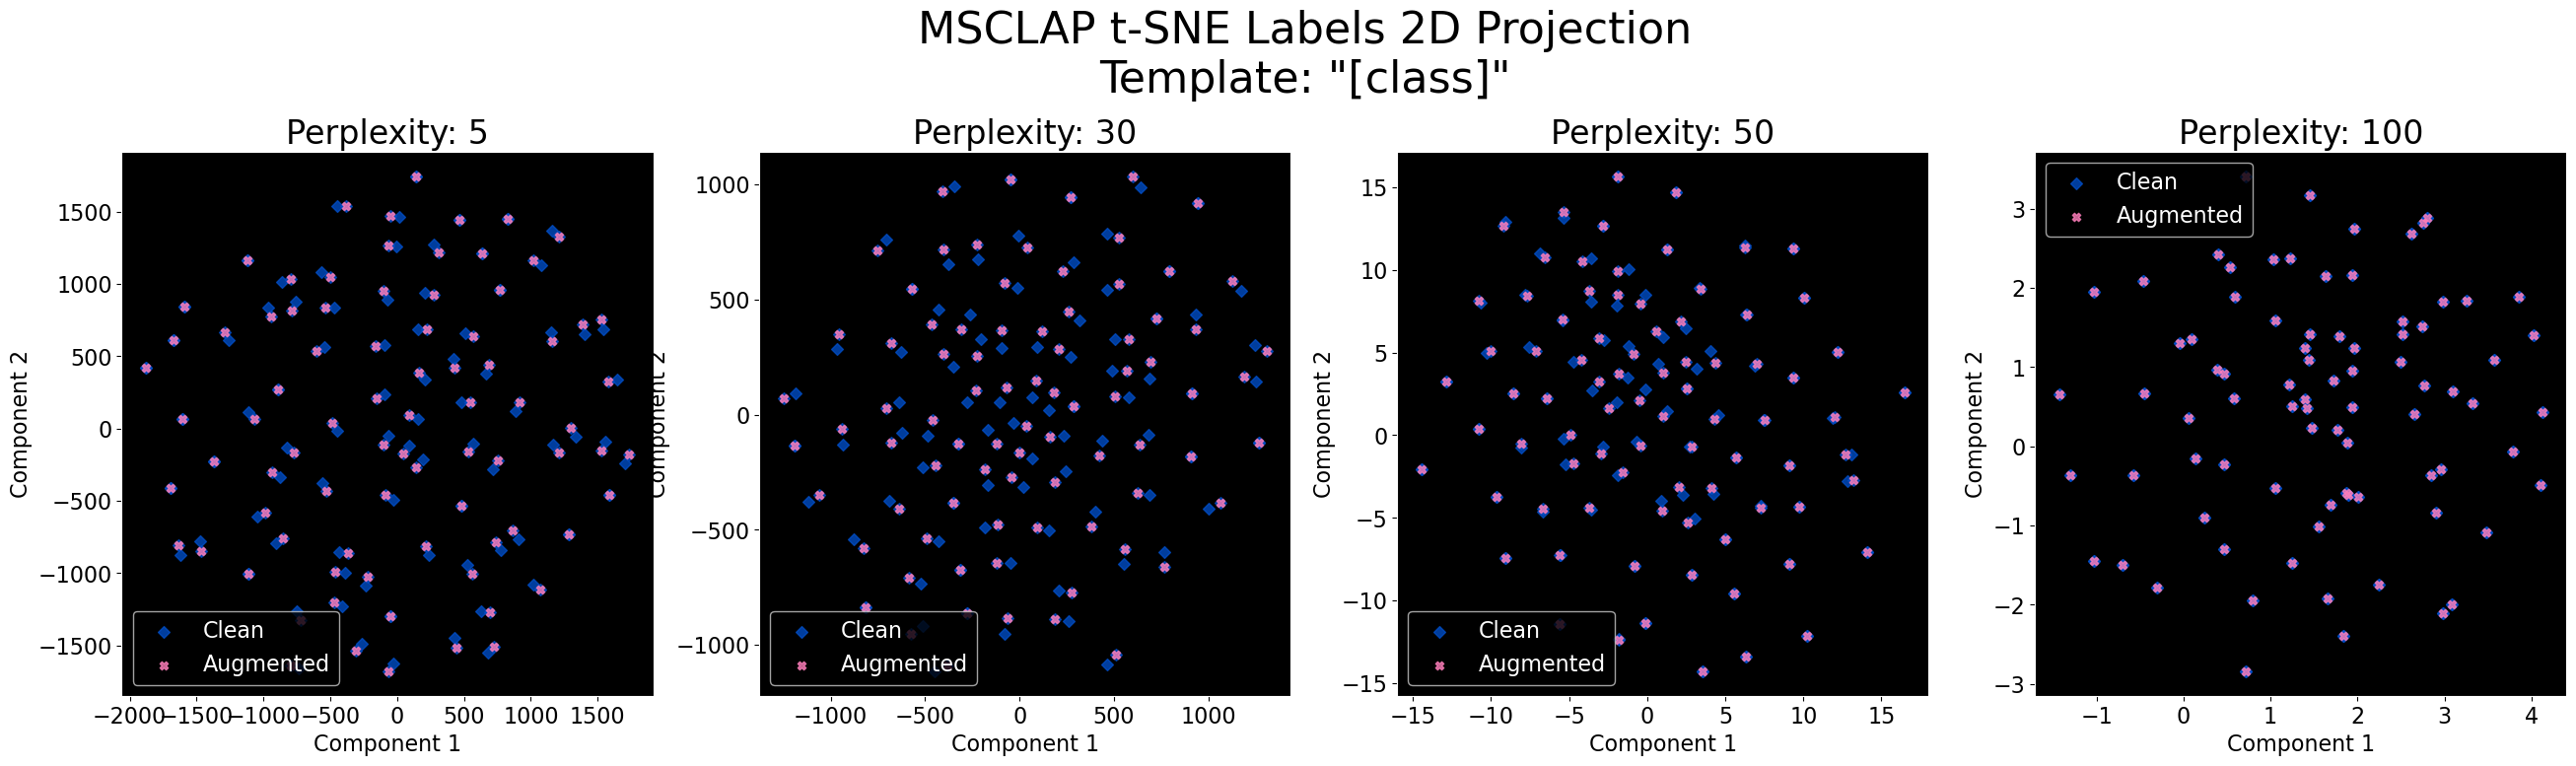

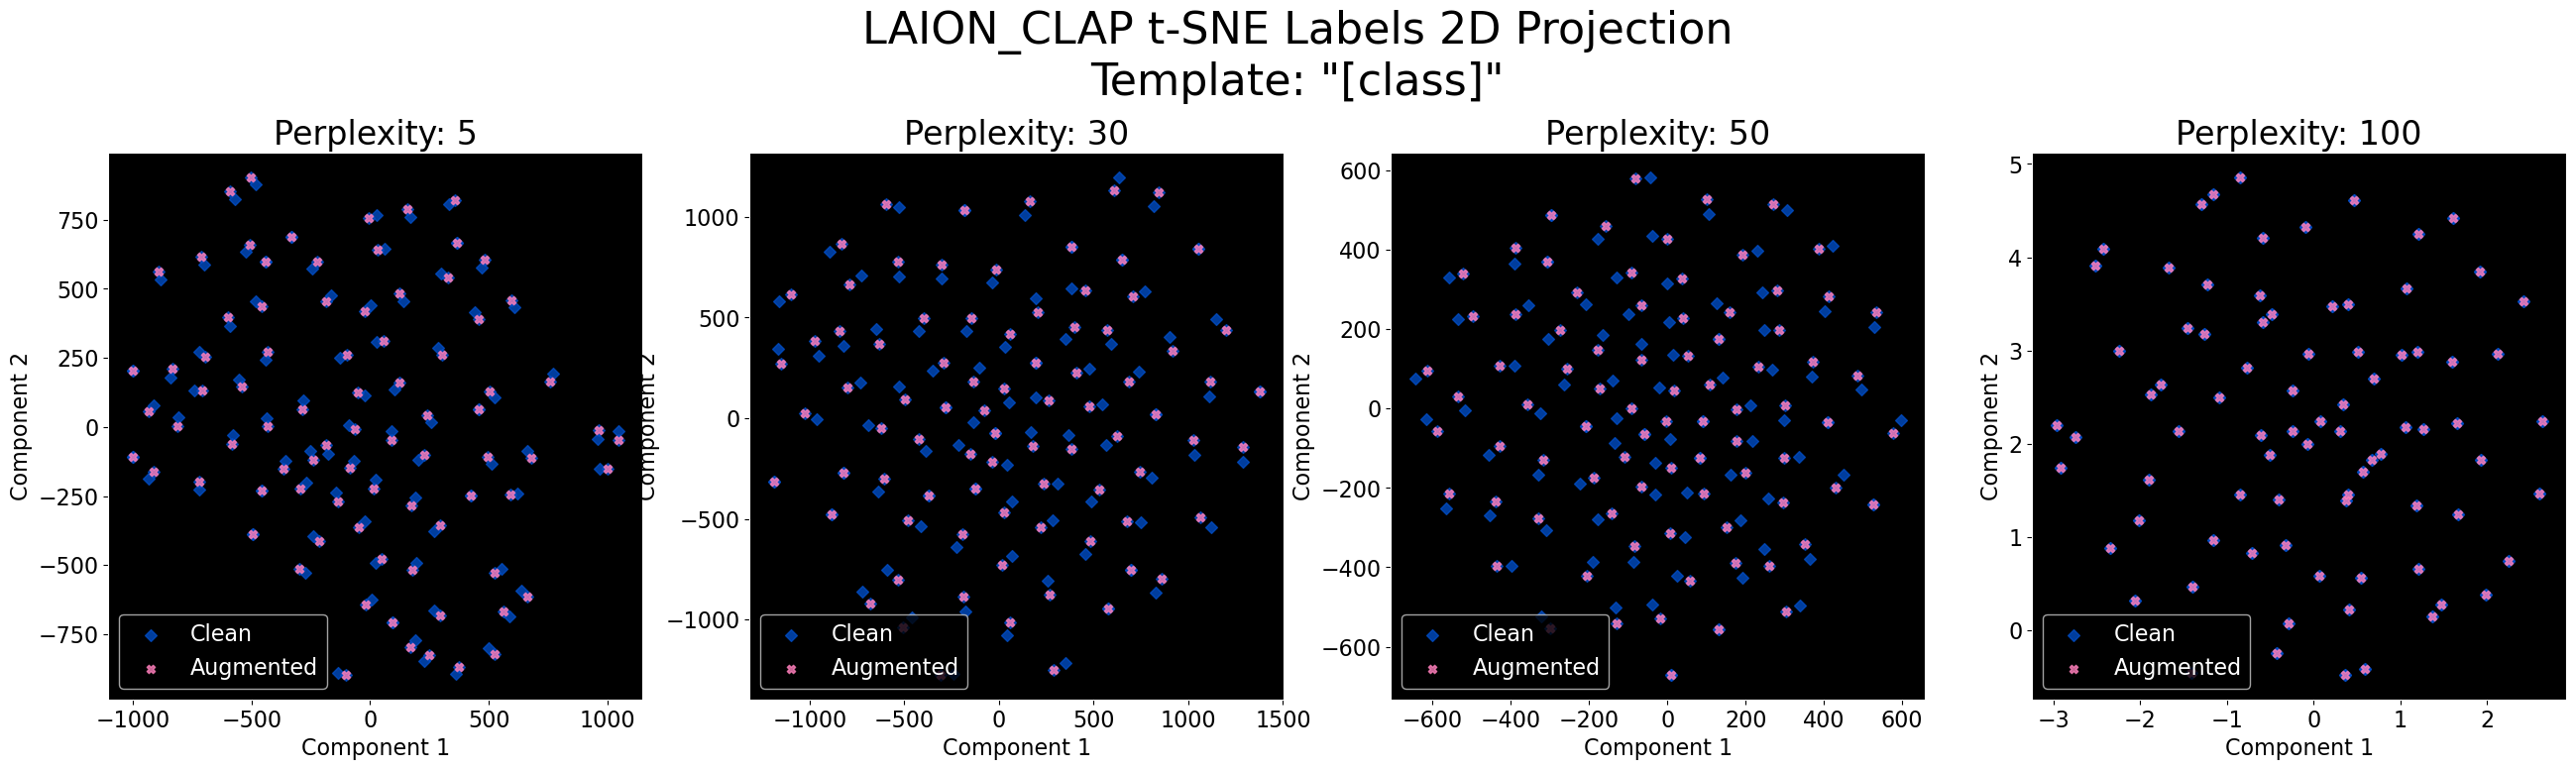

In [52]:
plt.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "black",
    "axes.facecolor": "black",
    "axes.edgecolor": "white",
    "axes.labelcolor": "black",
    "xtick.color": "black",
    "ytick.color": "black",
    "grid.color": "lightgray",
    "legend.facecolor": "black",
    "legend.labelcolor" : "white",
    "figure.facecolor": "white",
    "figure.edgecolor": "white",
    "savefig.facecolor": "white",
    "savefig.edgecolor": "white"})  

# Plotting 2D Projections
for projection, model_name in zip([msclap_projected_embs, laion_projected_embs], ["MSCLAP", "LAION_CLAP"]):
    fig, axes = plt.subplots(1, len(preplexities), figsize=(32,8))
    class_names = ['Clean','Augmented']
    samples_per_class = len(ucs_classes['class_to_int'].keys()) # Track where each class is in the vertical stack of samples

    for i, ax in enumerate(axes):
        for j, class_name in enumerate(class_names):
            if (class_name == 'Clean'):
                color = "#004DC6"
                marker = "D"
            
            if (class_name == 'Augmented'):
                color = "#fd7eba"
                marker = "X"

            ax.scatter(projection[i][j*samples_per_class:,0], projection[i][j*samples_per_class:,1], label=class_name, marker=marker, c=color, cmap=plt.cm.tab20b, alpha=.8)

            ax.set_title(f"Perplexity: {preplexities[i]}", fontsize=24)
            ax.set_xlabel("Component 1", fontsize=16)
            ax.set_ylabel("Component 2", fontsize=16)
            ax.tick_params(axis='both', which='major', labelsize=16)
            ax.legend(loc='lower left', fontsize="16")

    if (template == ""):
        fig.suptitle(f"{model_name} t-SNE Labels 2D Projection\nTemplate: \"[class]\"", fontsize=32)
    else:
        fig.suptitle(f"{model_name} t-SNE Labels 2D Projection\nTemplate: \"{template.strip()} [class]\"", fontsize=32)
    fig.subplots_adjust(top=0.8)
    plt.legend(fontsize=16)
    plt.savefig(f"{model_name.lower()}-template_augmentation-tsne-template_idx_{template_idx}.png", dpi=360, bbox_inches="tight")

## 2D Projection of Contrastive (Text-Audio) Embedding with t-SNE

This section projects both audio and text embeddings to the same 2D plane.

In [53]:
audio_folds_to_project = 10

class_names = ['Clean Label','Augmented Label', 'Audio']
#for i in range(audio_folds_to_project):
#    class_names.append(f"Audio Fold {i+1}")

# Stack all embeddings vertically
msclap_stacked_text_audio_embeddings = torch.concat((msclap_stacked_text_embeddings, k_fold_200_audio_embeddings_msclap[0]), dim=0)
laion_stacked_text_audio_embeddings = torch.concat((laion_stacked_text_embeddings, k_fold_200_audio_embeddings_laion[0]), dim=0)
# Exclude the dimension we already concatenated.
for i, (fold_msclap, fold_laion) in enumerate(zip(k_fold_200_audio_embeddings_msclap[1:], k_fold_200_audio_embeddings_laion[1:])): 
    msclap_stacked_text_audio_embeddings = torch.concat((msclap_stacked_text_audio_embeddings, fold_msclap), dim=0)
    laion_stacked_text_audio_embeddings = torch.concat((laion_stacked_text_audio_embeddings, fold_laion), dim=0)
    if (i == audio_folds_to_project-1) : break # Add 10 audio folds

msclap_text_audio_pca = PCA(n_components=75).fit_transform(msclap_stacked_text_audio_embeddings.cpu())
laion_text_audio_pca = PCA(n_components=75).fit_transform(laion_stacked_text_audio_embeddings.detach().cpu())

preplexities = [5, 30, 50, 100]
msclap_projected_contrastive_embs = []
laion_projected_contrastive_embs = []
for preplexity in preplexities:
    msclap_projected_contrastive_embs.append(TSNE(n_components=2, perplexity=preplexity, n_iter=tsne_iterations, random_state=seed).fit_transform(msclap_text_audio_pca))
    laion_projected_contrastive_embs.append(TSNE(n_components=2, perplexity=preplexity, n_iter=tsne_iterations, random_state=seed).fit_transform(laion_text_audio_pca))

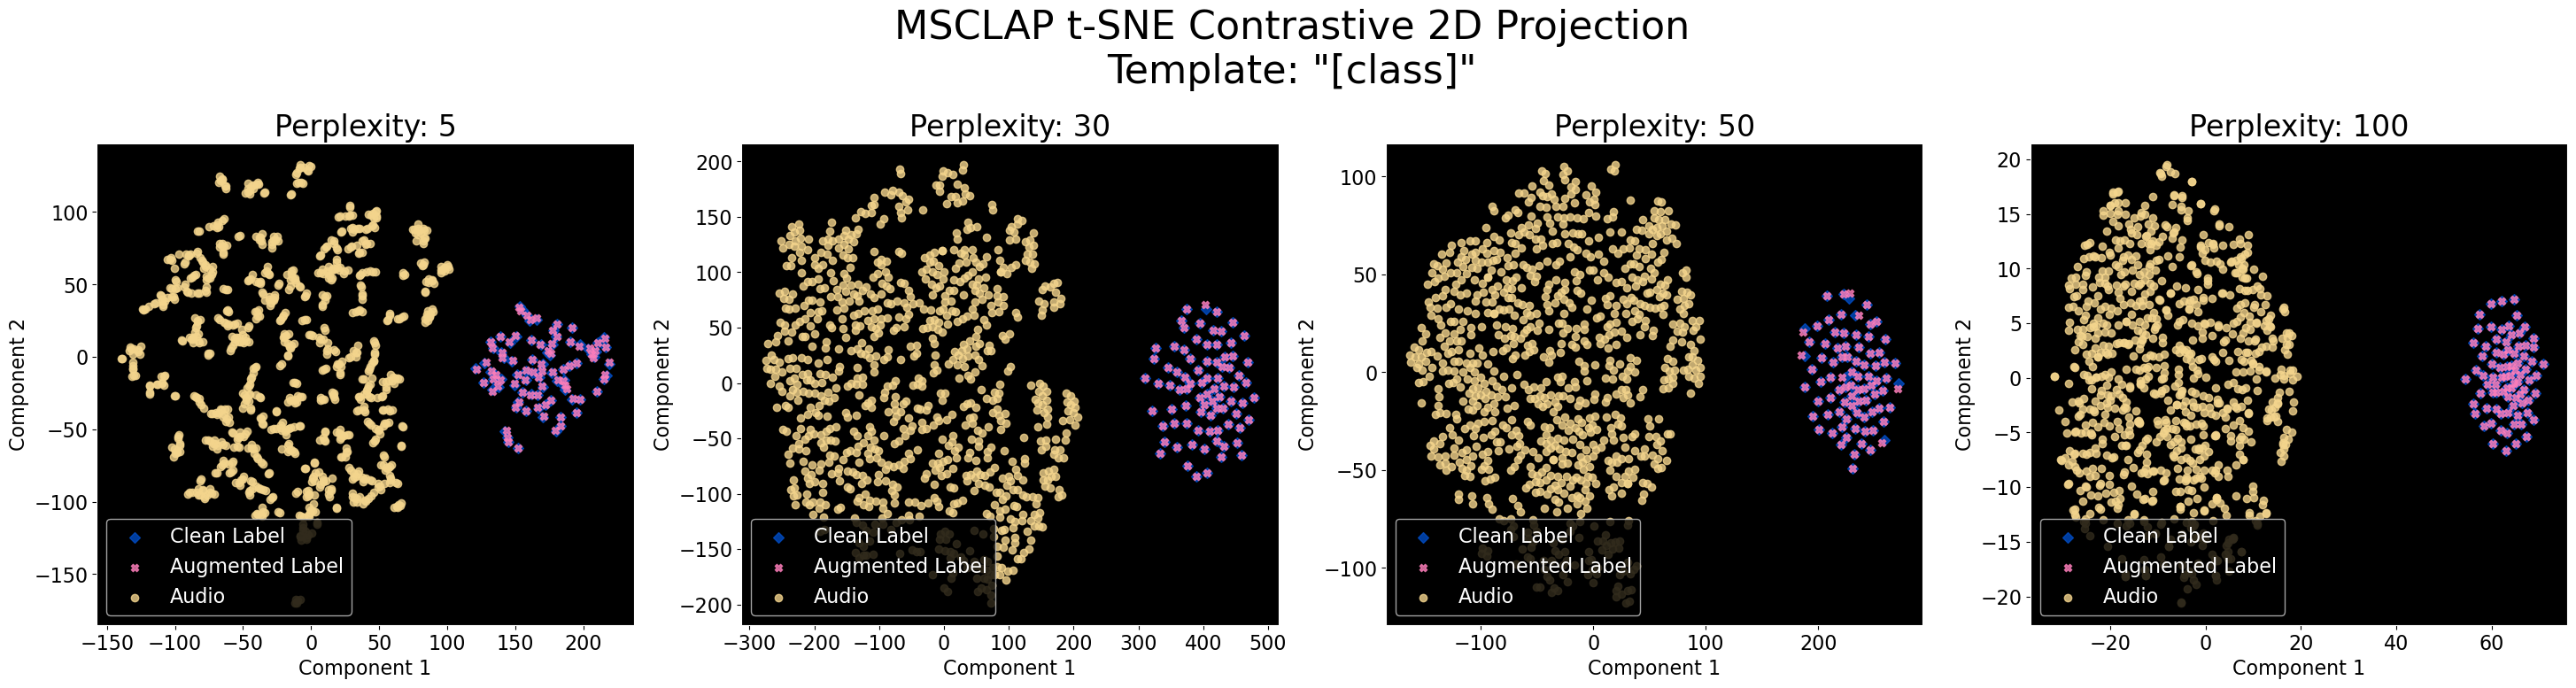

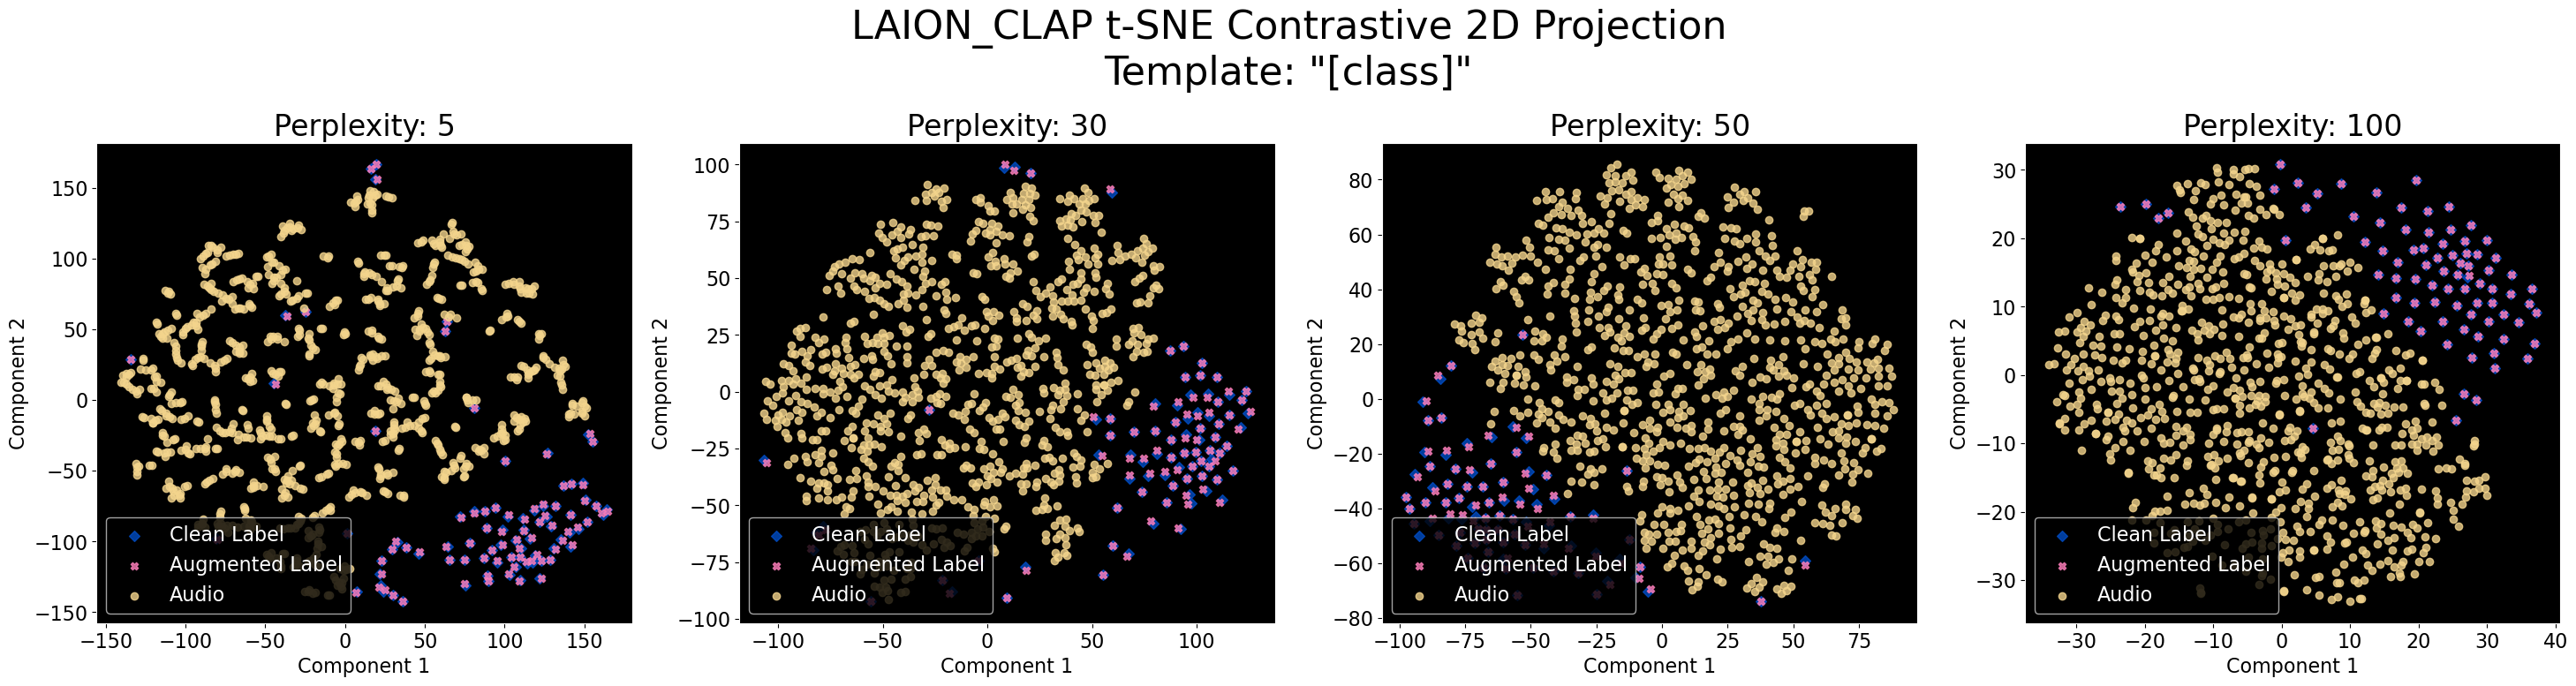

In [54]:
plt.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "black",
    "axes.facecolor": "black",
    "axes.edgecolor": "white",
    "axes.labelcolor": "black",
    "xtick.color": "black",
    "ytick.color": "black",
    "grid.color": "lightgray",
    "legend.facecolor": "black",
    "legend.labelcolor" : "white",
    "figure.facecolor": "white",
    "figure.edgecolor": "white",
    "savefig.facecolor": "white",
    "savefig.edgecolor": "white"}) 

# Plot contrastive 2D projections
for projection, model_name in zip([msclap_projected_contrastive_embs, laion_projected_contrastive_embs], ["MSCLAP", "LAION_CLAP"]): # projection shape = 4, 1055, 2
    fig, axes = plt.subplots(1, len(preplexities), figsize=(36,8))
    # Track where each class is in the vertical stack of samples
    samples_per_class = len(ucs_classes['class_to_int'].keys()) 

    # i = the current perplexity
    for i, ax in enumerate(axes):
        for n, name in enumerate(class_names):
            color = '#F4D58D' # Default color
            marker = 'o' # Default marker
            x = projection[i][n*samples_per_class:(n+1)*samples_per_class:,0]
            y = projection[i][n*samples_per_class:(n+1)*samples_per_class:,1]

            if("clean" in name.lower()):
                color = '#004DC6'
                marker = 'D'

            if ("augmented" in name.lower()):
                color = '#fd7eba'
                marker = 'X'

            if("audio" in name.lower()):
                name = "Audio"
                x = projection[i][n*samples_per_class::,0]
                y = projection[i][n*samples_per_class::,1]

            ax.scatter(
                x, # Column 0, i.e. PCA Component 1
                y, # Column 1, i.e. PCA Component 2
                label=name, marker=marker, c=color, cmap=plt.cm.tab20b, alpha=.8) #cmaps: tab20b, magma
            
            handle, label = ax.get_legend_handles_labels()

            ax.set_title(f"Perplexity: {preplexities[i]}", fontsize=24)
            ax.set_xlabel("Component 1", fontsize=16)
            ax.set_ylabel("Component 2", fontsize=16)
            ax.tick_params(axis='both', which='major', labelsize=16)
            ax.legend(loc='lower left', fontsize="16")

        #fig.legend(handle, label, loc='lower center', fontsize="16", ncol=len(class_names), bbox_to_anchor=(0,-0.1,1,1))

    if (template == ""):
        fig.suptitle(f"{model_name} t-SNE Contrastive 2D Projection\nTemplate: \"[class]\"", fontsize=32)
    else:
        fig.suptitle(f"{model_name} t-SNE Contrastive 2D Projection\nTemplate: \"{template.strip()} [class]\"", fontsize=32)
    fig.subplots_adjust(top=0.79)

    plt.savefig(f"{model_name.lower()}-template_augmentation-tsne-template_idx_{template_idx}-contrastive.png", dpi=360, bbox_inches="tight")

Covariance Result for CLAP MODEL 1: PearsonRResult(statistic=-0.2035824944533495, pvalue=0.5256697249349859)
Covariance Result for CLAP MODEL 2: PearsonRResult(statistic=-0.35739923038785654, pvalue=0.25405959267891476)
Covariance Result for BOTH, STANDARDIZED: PearsonRResult(statistic=-0.36763841614780046, pvalue=0.23971778477453057)


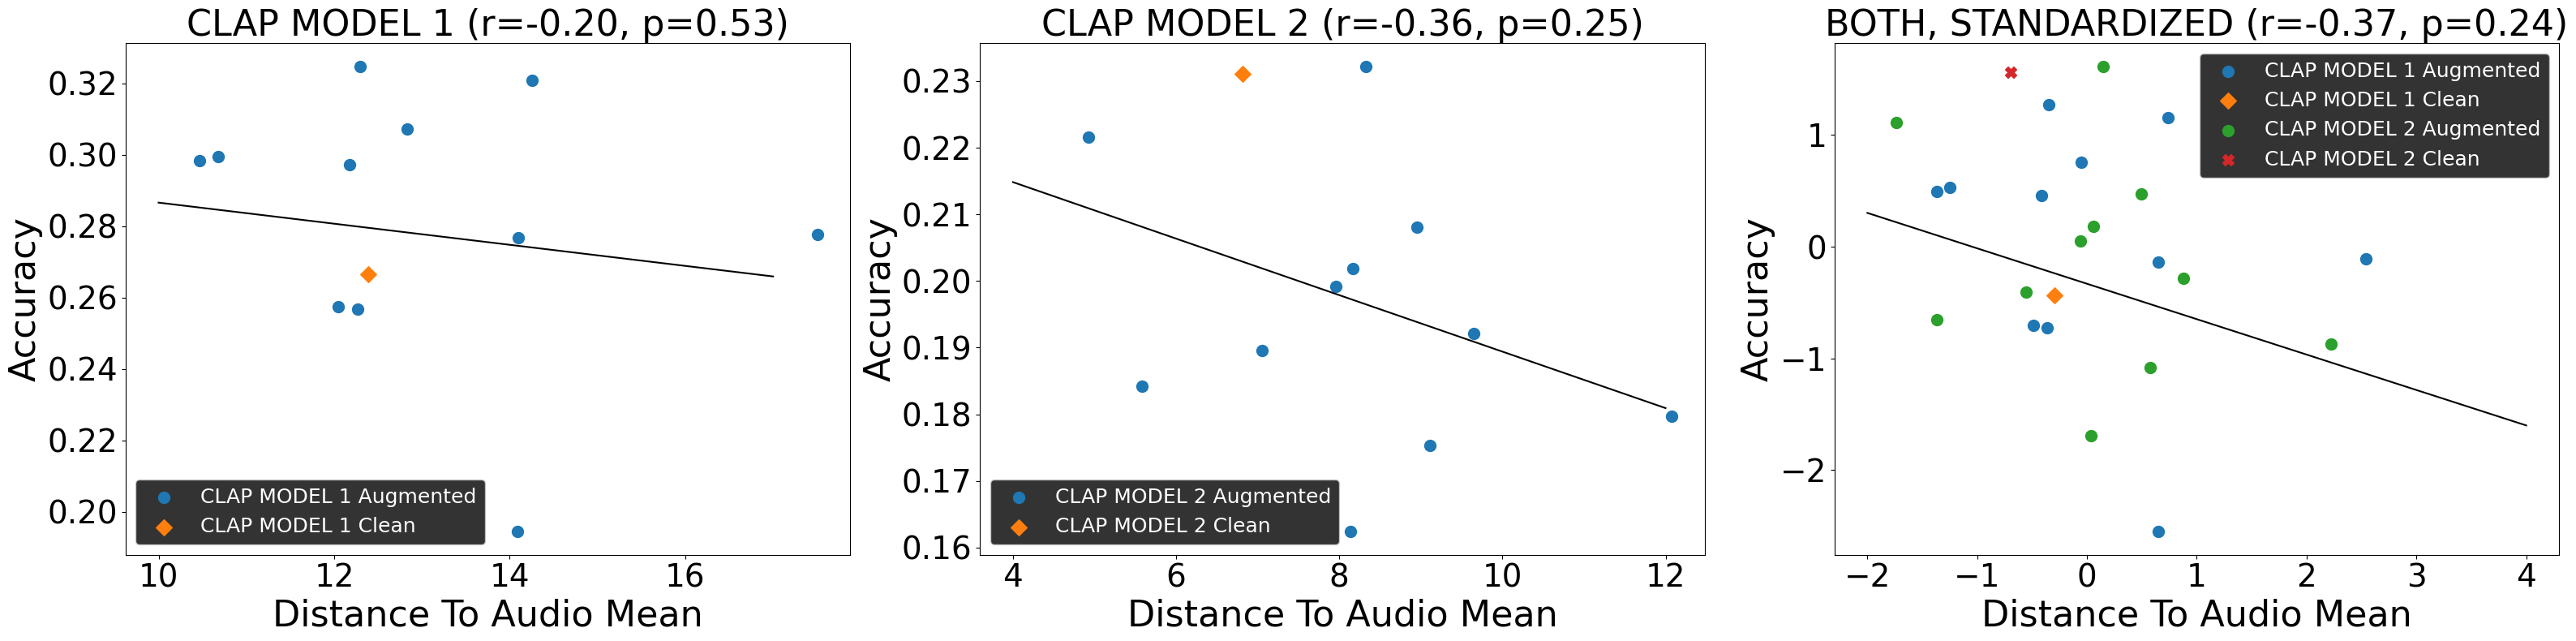

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr, linregress

with open ('logs/kfold200-zero_shot_temp_aug_consolidated.json', 'r') as f:
    log_metrics = json.load (f)

with open ('logs/kfold200-zero_shot-cluster_parameters_2024_05_07-20_54_41.json', 'r') as f:
    log = json.load (f)

plt.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "black",
    "axes.facecolor": "white", # Backgrond
    "axes.edgecolor": "black", # Borders
    "axes.labelcolor": "black",
    "xtick.color": "black",
    "ytick.color": "black",
    "grid.color": "lightgray",
    "legend.facecolor": "black",
    "legend.labelcolor" : "white",
    "figure.facecolor": "white",
    "figure.edgecolor": "white",
    "savefig.facecolor": "white",
    "savefig.edgecolor": "white"}) 

# Compute distance between clusters. Note: first element in ['augmented'] is "", or "clean", so we don't have to worry about it.
ms_dist_to_audio = [np.abs(log['results']['MSCLAP'][temp]['audio']['mean'] - log['results']['MSCLAP'][temp]['augmented']['mean']) for temp in log['results']['MSCLAP']]
laion_dist_to_audio = [np.abs(log['results']['LAION_CLAP'][temp]['audio']['mean'] - log['results']['LAION_CLAP'][temp]['augmented']['mean']) for temp in log['results']['LAION_CLAP']]
ms_accuracies = [log_metrics['results'][n]['msclap']['accuracy'] for n in log_metrics['results']]
laion_accuracies = [log_metrics['results'][n]['laion']['accuracy'] for n in log_metrics['results']]

fig, axes = plt.subplots(1, 3, figsize=(32,8))
#plt.suptitle("Linear Regression", y=1.05, fontsize=32)

for i, title in enumerate(['MSCLAP', 'LAION CLAP', 'BOTH, STANDARDIZED']):
    ax = axes[i]

    if (title == 'MSCLAP'):
        dist_to_audio = ms_dist_to_audio
        acc = ms_accuracies
        res = pearsonr(dist_to_audio, acc)
        x_train, x_test, y_train, y_test = train_test_split(dist_to_audio, acc, test_size=0.1, random_state=1337)
        ax.scatter(dist_to_audio[1:], acc[1:], label=f"{title} Augmented", s=100)
        ax.scatter(dist_to_audio[0], acc[0], label=f"{title} Clean", marker='D', s=100)
    elif (title == "LAION CLAP"):
        dist_to_audio = laion_dist_to_audio
        acc = laion_accuracies
        res = pearsonr(dist_to_audio, acc)
        x_train, x_test, y_train, y_test = train_test_split(dist_to_audio, acc, test_size=0.1, random_state=1337)
        ax.scatter(dist_to_audio[1:], acc[1:], label=f"{title} Augmented", s=100)
        ax.scatter(dist_to_audio[0], acc[0], label=f"{title} Clean", marker='D', s=100)
    else:
        # Standardize
        ms_dist_to_audio = (np.array(ms_dist_to_audio) - np.array(ms_dist_to_audio).mean()) / np.array(ms_dist_to_audio).std()
        laion_dist_to_audio = (np.array(laion_dist_to_audio) - np.array(laion_dist_to_audio).mean()) / np.array(laion_dist_to_audio).std()
        ms_accuracies = (np.array(ms_accuracies) - np.array(ms_accuracies).mean()) / np.array(ms_accuracies).std()
        laion_accuracies = (np.array(laion_accuracies) - np.array(laion_accuracies).mean()) / np.array(laion_accuracies).std()
        res = pearsonr(ms_dist_to_audio + laion_dist_to_audio, ms_accuracies + laion_accuracies)
        #Split
        x_train, x_test, y_train, y_test = train_test_split(ms_dist_to_audio + laion_dist_to_audio, ms_accuracies + laion_accuracies, test_size=0.2, random_state=1337)

        # Trash code, no time.
        for lab in ["MSCLAP", "LAION CLAP"]:
            if (lab == "MSCLAP"):
                dist_to_audio = ms_dist_to_audio
                acc = ms_accuracies
                marker = 'D'
            else:
                dist_to_audio = laion_dist_to_audio
                acc = laion_accuracies
                marker = 'X'

            ax.scatter(dist_to_audio[1:], acc[1:], label=f"{lab} Augmented", s=100)
            ax.scatter(dist_to_audio[0], acc[0], label=f"{lab} Clean", marker=marker, s=100)
    
    regressor = LinearRegression()
    regressor.fit(np.array(x_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1))
    LinearRegression()

    y_pred = regressor.predict(np.array(x_test).reshape(-1, 1))

    ax.set_ylabel("Accuracy", fontsize=32)
    ax.set_xlabel("Distance To Audio Mean", fontsize=32)
    ax.tick_params(axis='both', which='major', labelsize=28)
    
    ax.legend(fontsize="18", loc='best')
    # Slope = mx+c
    delta_x = (y_pred[0] - y_pred[1]) / (x_test[0] - x_test[1])

    print(f"Covariance Result for {title}: {res}")
    x_max = np.ceil(np.array(x_train).max())
    x_min = np.floor(np.array(x_train).min())

    lin_res = linregress(x_test, y_pred.flatten())
    x_vals = np.arange(x_min, x_max, 1)
    y_vals = lin_res.intercept + lin_res.slope * x_vals

    ax.set_title(f"{title} (r={res.statistic:.2f}, p={res.pvalue:.2f})", fontsize=32)
    ax.plot(x_vals, y_vals, color='k', linestyle='-')

plt.tight_layout()
plt.savefig("Linear Regression.pdf", bbox_inches='tight')